In [21]:
from catboost import CatBoostClassifier
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
from sklearn.preprocessing import StandardScaler
from fancyimpute import IterativeImputer
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier

from sklearn.model_selection import GridSearchCV

# seed
# import os
# import random
# os.environ['PYTHONHASHSEED']=str(271828)
# random.seed(271828)
# np.random.seed(271828)


In [22]:

def PCL_calculator(df):

    symptomatic_cutoff = 2
    intrusion = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH', 'q6.4_UPSET', 'q6.5_PHYS']
    avoidance = ['q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES', 'q6.9_DISINT', 'q6.10_DTACH',
                 'q6.11_NUMB', 'q6.12_FUTRE']
    tred = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH']
    only_avoidance = ['q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES']
    hypertension = ['q6.13_SLEEP', 'q6.14_ANGER', 'q6.15_CONC', 'q6.16_HYPER', 'q6.17_STRTL']
    depression = ['q6.9_DISINT', 'q6.10_DTACH', 'q6.11_NUMB', 'q6.12_FUTRE']

    df[intrusion + avoidance + hypertension].fillna(df[intrusion + avoidance + hypertension].mean(axis=0))
    intrusion_cuoff = 1
    avoidance_cuoff = 3
    hypertension_cuoff = 2
    only_avoidance_cutoff = 1
    depression_cutoff = 2
    tred_cutoff = 1

    df['PCL_score'] = (df[intrusion + avoidance + hypertension]).sum(axis=1)
    df['PCL_mean'] = (df[intrusion + avoidance + hypertension]).mean(axis=1)
    df['PCL_std'] = (df[intrusion + avoidance + hypertension]).std(axis=1)
    

    df['intrusion'] = (df[intrusion] > symptomatic_cutoff).sum(axis=1)
    df['intrusion_mean'] = (df[intrusion] > symptomatic_cutoff).mean(axis=1)
    df['intrusion_std'] = (df[intrusion] > symptomatic_cutoff).std(axis=1)
    df['intrusion_cutoff'] = (df['intrusion'] >= intrusion_cuoff).astype(int)

    df['avoidance'] = (df[avoidance] > symptomatic_cutoff).sum(axis=1)
    df['avoidance_mean'] = (df[avoidance] > symptomatic_cutoff).mean(axis=1)
    df['avoidance_std'] = (df[avoidance] > symptomatic_cutoff).std(axis=1)
    df['avoidance_cutoff'] = (df['avoidance'] >= avoidance_cuoff).astype(int)

    df['depression'] = (df[depression] > symptomatic_cutoff).sum(axis=1)
    df['depression_mean'] = (df[depression] > symptomatic_cutoff).mean(axis=1)
    df['depression_std'] = (df[depression] > symptomatic_cutoff).std(axis=1)
    df['depression_cutoff'] = (df['depression'] >= depression_cutoff).astype(int)

    df['hypertention'] = (df[hypertension] > symptomatic_cutoff).sum(axis=1)
    df['hypertention_mean'] = (df[hypertension] > symptomatic_cutoff).mean(axis=1)
    df['hypertention_std'] = (df[hypertension] > symptomatic_cutoff).std(axis=1)
    df['hypertention_cutoff'] = (df['hypertention'] >= hypertension_cuoff).astype(int)

    df['tred'] = (df[tred] > symptomatic_cutoff).sum(axis=1)
    df['tred_mean'] = (df[tred] > symptomatic_cutoff).mean(axis=1)
    df['tred_std'] = (df[tred] > symptomatic_cutoff).std(axis=1)
    df['tred_cutoff'] = df['tred'] >= tred_cutoff

    df['only_avoidance'] = (df[only_avoidance] > symptomatic_cutoff).sum(axis=1)
    df['only_avoidance_mean'] = (df[only_avoidance] > symptomatic_cutoff).sum(axis=1)
    df['only_avoidance_std'] = (df[only_avoidance] > symptomatic_cutoff).sum(axis=1)
    df['only_avoidance_cutoff'] = df['only_avoidance'] >= only_avoidance_cutoff

    #df['regression_cutoff_33'] = df['sum'] >= 33
    #df['regression_cutoff_50'] = df['sum'] >= 49
    df['diagnosis'] = ((df['hypertention_cutoff']) & (df['avoidance_cutoff']) & (df['intrusion_cutoff']) & (df['PCL_score'] >= 49))

    return df



In [23]:
path = "C:\‏‏PycharmProjects\PTSD\Data\PTSD.xlsx"
df = pd.read_excel(path)
#combine with specifics of answers
df_pcl2 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL2.xlsx")
df_pcl2 = PCL_calculator(df_pcl2)

df_pcl1 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL1.xlsx")
df_pcl1 = PCL_calculator(df_pcl1)

df = df.merge(df_pcl1, on="ID", how='outer')
df = df.merge(df_pcl2, suffixes=('_pcl1', '_pcl2'), on="ID", how='outer')

df_pcl3 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL3.xlsx")
df_pcl3 = PCL_calculator(df_pcl3)
df = df.merge(df_pcl3.drop(['PCL3_Strict', 'pcl3', 'PCL3_Broad'], axis=1), on="ID", how='outer')
# rmoving missing Y's
df = df[~(df['PCL_Strict3'].isna()) & ~(df['diagnosis'].isna())]

df.iloc[np.where(df['PCL_Strict3'] != df['diagnosis'])]['PCL_Strict3'] = True


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## features 

In [24]:

features = ["highschool_diploma", "dyslexia", "ADHD", "phq1", "lot1", "trait1",
                "state1", "PCL1", "PCL_Broad1", "PCL_Strict1", "phq2", "lot2", "trait2", "state2", "PCL2", "PCL_Broad2",
                "PCL_Strict2", "active_coping1", "planning1", "positive_reframing1", "acceptance1",
                "humor1", "religion1", "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1", "active_coping2", "planning2",
                "positive_reframing2", "acceptance2", "humor2", "religion2", "emotional_support2",
                "instrumental_support2",
                "self_distraction2", "denial2", "venting2", "substance_use2", "behavioral_disengagement2",
                "self_blame2", "trauma_history8_1", 'q6.1_INTRU_pcl1', 
                'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                  'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                  'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                  'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1',
                  'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2',
                  'q6.5_PHYS_pcl2', 'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                  'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                  'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2',
            
            'PCL_score_pcl1', 'PCL_mean_pcl1', 'PCL_std_pcl1', 
            'intrusion_pcl1', 'intrusion_mean_pcl1', 'intrusion_std_pcl1',
            'intrusion_cutoff_pcl1', 
            'avoidance_pcl1', 'avoidance_mean_pcl1', 'avoidance_std_pcl1', 'avoidance_cutoff_pcl1', 
            'depression_pcl1', 'depression_mean_pcl1', 'depression_std_pcl1', 'depression_cutoff_pcl1',
            'hypertention_pcl1',
            'hypertention_mean_pcl1', 'hypertention_std_pcl1', 'hypertention_cutoff_pcl1',
            'tred_pcl1', 'tred_mean_pcl1', 
            'tred_std_pcl1', 'tred_cutoff_pcl1', 
            'only_avoidance_pcl1','only_avoidance_mean_pcl1', 'only_avoidance_std_pcl1', 
            'only_avoidance_cutoff_pcl1',
            
            'PCL_score_pcl2', 'PCL_mean_pcl2', 'PCL_std_pcl2', 'intrusion_pcl2', 'intrusion_mean_pcl2', 'intrusion_std_pcl2',
            'intrusion_cutoff_pcl2', 'avoidance_pcl2', 'avoidance_mean_pcl2', 'avoidance_std_pcl2', 'avoidance_cutoff_pcl2', 
            'depression_pcl2', 'depression_mean_pcl2', 'depression_std_pcl2', 'depression_cutoff_pcl2', 'hypertention_pcl2',
            'hypertention_mean_pcl2', 'hypertention_std_pcl2', 'hypertention_cutoff_pcl2', 'tred_pcl2', 'tred_mean_pcl2', 
            'tred_std_pcl2', 'tred_cutoff_pcl2', 'only_avoidance_pcl2','only_avoidance_mean_pcl2', 'only_avoidance_std_pcl2', 
            'only_avoidance_cutoff_pcl2'
]

In [25]:

t2_features = [
    "lot2", "trait2", "state2", "PCL2", "PCL_Broad2", "PCL_Strict2", "phq2",

    "active_coping2", "planning2", "positive_reframing2", "acceptance2", "humor2", 
    "religion2", "emotional_support2", "instrumental_support2", "self_distraction2",
    "denial2", "venting2", "substance_use2", "behavioral_disengagement2", "self_blame2",
    
    'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2', 'q6.5_PHYS_pcl2',
    'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                    'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                    'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2'
]
t1_features =[ "phq1", "lot1", "trait1","state1", "PCL1", "PCL_Broad1", "PCL_Strict1",
              
                    "active_coping1", "planning1", "positive_reframing1", "acceptance1", "humor1", "religion1",
                    "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                    "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1",
                'q6.1_INTRU_pcl1', 'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                    'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                    'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                    'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1']

## fill the missing values

In [26]:
target_feature = ['PCL_Strict3']

In [27]:
df1 = df[features + target_feature]

#df1 = df1.dropna(thresh=47)
df_t1 = df1[t1_features]
df_t2 = df1[t2_features]
df1 = df1[(df_t1.isna().astype(int).sum(axis=1)<38) | (df_t2.isna().astype(int).sum(axis=1)<38)]
df1["t1_missing"] = df_t1.isna().astype(int).sum(axis=1)==38
df1["t2_missing"] = df_t2.isna().astype(int).sum(axis=1)==38

    


In [28]:
for i in t1_features:
    df1["delta_"+i[:len(i)-1:]] = df1[i] - df1[i[:len(i)-1:]+"2"]
    features = features + ["delta_"+i[:len(i)-1:]]

In [29]:
df1['std_pos_coping_t1'] = df1[["active_coping1", "planning1", "positive_reframing1", "acceptance1", "humor1",
                    "religion1", "emotional_support1", "instrumental_support1", "self_distraction1","venting1"]].std(axis=1)
df1['std_neg_coping_t1'] = df1[["denial1", "substance_use1", "behavioral_disengagement1", "self_blame1"]].std(axis=1)

df1['std_pos_coping_t2'] = df1[["active_coping2", "planning2", "positive_reframing2", "acceptance2", "humor2",
                    "religion2", "emotional_support2", "instrumental_support2", "self_distraction2","venting2"]].std(axis=1)

df1['std_neg_coping_t2'] = df1[["denial2", "substance_use2", "behavioral_disengagement2", "self_blame2"]].std(axis=1)

features = features + ['std_pos_coping_t1', 'std_neg_coping_t1', 'std_pos_coping_t2', 'std_neg_coping_t2']
features.extend(["t1_missing", "t2_missing"])


## cut off the test set

In [30]:
#features = ['phq2', 'highschool_diploma', 'self_distraction2', 'substance_use2']

In [31]:
X, X_out, Y, y_out = train_test_split(df1[features], df1[target_feature[0]],
                                      test_size=0.25, random_state=1844, stratify=df1[target_feature[0]])


In [12]:
with open('features.txt', 'w') as f:
    for item in X.columns:
        f.write("%s\n" % item)

## the Model

## CV model of roc auc 

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [14]:

for j in range(2):
    for fold_ind, (train_ind, val_ind) in enumerate(StratifiedKFold(n_splits=5).split(X, Y)):
        X_train_cv = X.iloc[train_ind]
        y_train_cv = Y.iloc[train_ind]
        X_val_cv = X.iloc[val_ind]
        y_val_cv = Y.iloc[val_ind]

        cv = StratifiedKFold(5)


        print(f"fold = {fold_ind}")
        pipe = CatBoostClassifier(verbose=0)

        grid_params = [{
            'class_weights':[[1, 25], [1, 75], [1, 5]],
            'l2_leaf_reg': [100, 50, 10, 1],
            'depth': [6, 3]
        }]

        clf = GridSearchCV(pipe, grid_params, cv=cv, scoring='roc_auc')
        clf.fit(X_train_cv, y_train_cv.values.astype(int), early_stopping_rounds=15)
        print(f"fold = {fold_ind}, roc_auc = {clf.best_score_}, params = {clf.best_params_}")
        y_pred_target = clf.best_estimator_.predict_proba(X_val_cv)[:, 1]
        print(f"fold = {fold_ind} holdout set, roc_auc = {roc_auc_score(y_val_cv.astype(int), y_pred_target)}")

fold = 0


C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


fold = 0, roc_auc = 0.8306377312315555, params = {'class_weights': [1, 75], 'depth': 3, 'l2_leaf_reg': 100}
fold = 0 holdout set, roc_auc = 0.6964285714285714
fold = 1


C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


fold = 1, roc_auc = 0.7457179312399655, params = {'class_weights': [1, 75], 'depth': 3, 'l2_leaf_reg': 100}
fold = 1 holdout set, roc_auc = 0.7813852813852813
fold = 2


C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


fold = 2, roc_auc = 0.7428960666258221, params = {'class_weights': [1, 5], 'depth': 3, 'l2_leaf_reg': 100}
fold = 2 holdout set, roc_auc = 0.8846801346801347
fold = 3


C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


fold = 3, roc_auc = 0.7588605168868745, params = {'class_weights': [1, 75], 'depth': 3, 'l2_leaf_reg': 100}
fold = 3 holdout set, roc_auc = 0.8316498316498316
fold = 4


C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


fold = 4, roc_auc = 0.7433710717848541, params = {'class_weights': [1, 5], 'depth': 3, 'l2_leaf_reg': 100}
fold = 4 holdout set, roc_auc = 0.8207070707070707
fold = 0


C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


fold = 0, roc_auc = 0.8306377312315555, params = {'class_weights': [1, 75], 'depth': 3, 'l2_leaf_reg': 100}
fold = 0 holdout set, roc_auc = 0.6964285714285714
fold = 1


C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


fold = 1, roc_auc = 0.7457179312399655, params = {'class_weights': [1, 75], 'depth': 3, 'l2_leaf_reg': 100}
fold = 1 holdout set, roc_auc = 0.7813852813852813
fold = 2


KeyboardInterrupt: 

In [33]:

cv = StratifiedKFold(5)


print(f"fold = {fold_ind}")
pipe = CatBoostClassifier(verbose=0)

grid_params = [{
        'class_weights':[[1, 25], [1, 75], [1, 5]],
        'l2_leaf_reg': [100, 50, 10, 1],
        'depth': [6, 3]
}]

clf = GridSearchCV(pipe, grid_params, cv=cv, scoring='roc_auc')
clf.fit(X, Y.values.astype(int), early_stopping_rounds=15)
print(f"fold = {fold_ind}, roc_auc = {clf.best_score_}, params = {clf.best_params_}")
y_pred_target = clf.best_estimator_.predict_proba(X_out)[:, 1]
print(f"fold = {fold_ind} holdout set, roc_auc = {roc_auc_score(y_out.astype(int), y_pred_target)}")

fold = 2


C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


fold = 2, roc_auc = 0.8557797947002492, params = {'class_weights': [1, 5], 'depth': 6, 'l2_leaf_reg': 100}
fold = 2 holdout set, roc_auc = 0.8686746987951808


In [34]:
for i, j in sorted(zip(clf.best_estimator_.feature_importances_, X.columns), reverse=True):
    print(j, i)

phq2 10.963438470867771
highschool_diploma 6.700694307022289
self_distraction2 3.867450650332993
substance_use2 2.430465186087021
delta_phq 1.9466885508360183
state2 1.8706253517332505
lot2 1.8522986263742365
q6.15_CONC_pcl2 1.7612612949242414
PCL1 1.674175459001654
trauma_history8_1 1.589918892982323
std_pos_coping_t1 1.4134084504573399
denial2 1.397932936485389
q6.8_AMNES_pcl1 1.3608700776854388
PCL_std_pcl2 1.2248693157639339
depression_mean_pcl1 1.1447576241942972
std_neg_coping_t2 1.1399918968734095
PCL_score_pcl1 1.1252602577204631
PCL2 1.1129189470582141
trait2 1.0925554915312015
q6.16_HYPER_pcl1 1.0896817573374844
q6.14_ANGER_pcl2 1.0111898626589777
delta_q6.16_HYPER_pcl 0.994757674406572
PCL_mean_pcl2 0.9817916680351457
avoidance_mean_pcl1 0.9560724089162826
PCL_score_pcl2 0.9395183989149042
delta_q6.8_AMNES_pcl 0.9337201304967547
delta_state 0.929224298032868
intrusion_std_pcl1 0.9086870333346608
phq1 0.8975636849615202
depression_cutoff_pcl2 0.8902929716560062
ADHD 0.8779775

In [35]:
clf.best_estimator_.feature_importances_

array([6.70069431e+00, 8.69593266e-02, 8.77977512e-01, 8.97563685e-01,
       6.11129729e-01, 3.27296810e-01, 2.84846064e-01, 1.67417546e+00,
       1.57508669e-01, 1.66590293e-03, 1.09634385e+01, 1.85229863e+00,
       1.09255549e+00, 1.87062535e+00, 1.11291895e+00, 2.50149964e-01,
       8.60363600e-02, 8.17623606e-02, 1.56555866e-01, 5.07527242e-01,
       4.25939883e-01, 7.54550633e-01, 4.07335481e-01, 2.00293520e-01,
       1.05285925e-01, 4.98289484e-01, 2.02410068e-01, 2.75974365e-01,
       3.92633025e-01, 5.20834735e-01, 2.20448061e-01, 4.99215133e-01,
       1.44096394e-01, 2.33747323e-01, 8.70290297e-02, 4.81792735e-01,
       8.01204840e-01, 2.11513706e-01, 7.16611416e-01, 3.86745065e+00,
       1.39793294e+00, 4.02168264e-01, 2.43046519e+00, 3.93544413e-01,
       2.09996447e-01, 1.58991889e+00, 9.62085878e-02, 1.84130971e-01,
       8.24615713e-02, 2.04435714e-01, 5.28729302e-02, 3.81580151e-01,
       4.33320970e-01, 1.36087008e+00, 4.93969381e-01, 3.86071279e-01,
      

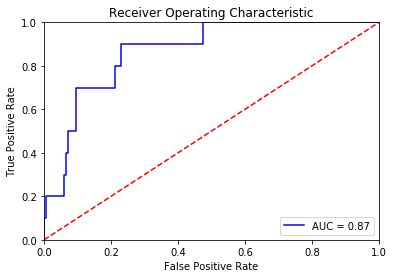

In [36]:

fpr, tpr, threshold = roc_curve(y_out, y_pred_target)
roc_auc = auc(fpr, tpr)

                    # method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

In [20]:
X.shape

(528, 4)